In [163]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [165]:
# Load the data
df = pd.read_csv('Data/RedfinDataReadyData.csv')

In [167]:
df.head()

,SALE TYPE,SOLD DATE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIPCODE,PRICE,BEDS,BATHS,LOCATION,SQUARE FEET,LOT SIZE,YEAR BUILT,$/SQUARE FEET,HOA/MONTH,LATITUDE,LONGITUDE
0,PAST SALE,March-28-2025,Single Family Residential,2695 Hilltop Loop,Apopka,FL,32712,619500,4,3.5,VISTA RESERVE PH 2,2915,12482.0,2022.0,213,136.0,28.721566,-81.534460
1,PAST SALE,NaN,Single Family Residential,226 N Lake Ave,Apopka,FL,32703,243200,3,2.0,NaN,2392,56307.0,1953.0,102,NaN,28.681056,-81.513936
2,PAST SALE,NaN,Single Family Residential,2856 Rock Springs Rd,Apopka,FL,32712,220000,2,1.0,NaN,1024,23114.0,1935.0,215,NaN,28.726776,-81.509458
3,PAST SALE,March-21-2025,Single Family Residential,650 Creeping Fig St,Apopka,FL,32703,812160,5,4.5,EMERSON POINTE,2731,8319.0,2025.0,297,NaN,28.654309,-81.518276
4,PAST SALE,March-10-2025,Single Family Residential,1765 Riderrain Ln,Apopka,FL,32703,510490,4,3.0,BRONSONS RIDGE 60S,2387,7405.0,2024.0,214,122.0,28.661695,-81.537144


In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SALE TYPE          289 non-null    object 
 1   SOLD DATE          275 non-null    object 
 2   PROPERTY TYPE      289 non-null    object 
 3   ADDRESS            289 non-null    object 
 4   CITY               288 non-null    object 
 5   STATE OR PROVINCE  289 non-null    object 
 6   ZIPCODE            289 non-null    int64  
 7   PRICE              289 non-null    int64  
 8   BEDS               289 non-null    int64  
 9   BATHS              289 non-null    float64
 10  LOCATION           274 non-null    object 
 11  SQUARE FEET        289 non-null    int64  
 12  LOT SIZE           287 non-null    float64
 13  YEAR BUILT         288 non-null    float64
 14  $/SQUARE FEET      289 non-null    int64  
 15  HOA/MONTH          203 non-null    float64
 16  LATITUDE           289 non

In [171]:
df['ZIPCODE'] = df['ZIPCODE'].astype('object')

In [173]:
df.groupby('ZIPCODE')['PRICE'].describe()

,count,mean,std,min,25%,50%,75%,max
ZIPCODE,,,,,,,,
32703,132.0,452290.651515,215807.662576,80000.0,333750.0,416490.0,520247.5,1355000.0
32712,151.0,463005.920530,122330.893761,171000.0,388000.0,443990.0,552500.0,800000.0
32776,1.0,307000.000000,NaN,307000.0,307000.0,307000.0,307000.0,307000.0
32798,3.0,369993.333333,190519.815330,150000.0,314995.0,479990.0,479990.0,479990.0
32832,1.0,375000.000000,NaN,375000.0,375000.0,375000.0,375000.0,375000.0
34761,1.0,475000.000000,NaN,475000.0,475000.0,475000.0,475000.0,475000.0


In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SALE TYPE          289 non-null    object 
 1   SOLD DATE          275 non-null    object 
 2   PROPERTY TYPE      289 non-null    object 
 3   ADDRESS            289 non-null    object 
 4   CITY               288 non-null    object 
 5   STATE OR PROVINCE  289 non-null    object 
 6   ZIPCODE            289 non-null    object 
 7   PRICE              289 non-null    int64  
 8   BEDS               289 non-null    int64  
 9   BATHS              289 non-null    float64
 10  LOCATION           274 non-null    object 
 11  SQUARE FEET        289 non-null    int64  
 12  LOT SIZE           287 non-null    float64
 13  YEAR BUILT         288 non-null    float64
 14  $/SQUARE FEET      289 non-null    int64  
 15  HOA/MONTH          203 non-null    float64
 16  LATITUDE           289 non

In [177]:
# Function to train and predict for a specific position
def train_and_predict(position, features):
    # Filter data for the specific position
    position_data = df[df['ZIPCODE'] == position].copy()
    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    # Prepare X and y
    X = position_data[features].fillna(0)
    y = position_data['PRICE'].fillna(0)

    # Reset index to preserve alignment
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    position_data = position_data.reset_index(drop=True)

    # Split and get indices
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, position_data.index, test_size=0.2, random_state=42
    )

    # Label split using true indices
    position_data.loc[idx_train, 'Data Split'] = 'Train'
    position_data.loc[idx_test, 'Data Split'] = 'Test'
    
    # Train the model
    rf = RandomForestRegressor(
        n_estimators=200, 
        max_depth=20, 
        random_state=42
    )
    rf.fit(X_train, y_train)

    # Evaluate the model
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)

    print(f"\n{position} - Training MAE: {mean_absolute_error(y_train, y_pred_train)}")
    print(f"{position} - Testing MAE: {mean_absolute_error(y_test, y_pred_test)}")

    # Feature importances
    feature_importances = rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    # Store predictions only for the correct subset
    train_df = position_data.loc[idx_train, ['ADDRESS', 'ZIPCODE', 'PRICE']].copy()
    train_df.loc[:, 'Data Split'] = 'Train'
    train_df.loc[:, 'PredictedPrice'] = y_pred_train

    test_df = position_data.loc[idx_test, ['ADDRESS', 'ZIPCODE', 'PRICE']].copy()
    test_df.loc[:, 'Data Split'] = 'Test'
    test_df.loc[:, 'PredictedPrice'] = y_pred_test

    return pd.concat([train_df, test_df], ignore_index=True)

    # Predict the 2024 fantasy points
    position_data.loc[:, 'PredictedPrice'] = rf.predict(X)
    
    return position_data[['ADDRESS', 'Data Split', 'ZIPCODE', 'PredictedPrice', 'PRICE']]

# Define feature sets for each position, including past PPR points and new features
# Define feature sets for each position, including past PPR points and new features
features = ['BEDS', 'BATHS', 'SQUARE FEET', 'LOT SIZE', 'YEAR BUILT', 'LATITUDE', 'LONGITUDE']

# Train and predict for all ZIP codes automatically
# Only include ZIPs with 2 or more rows
valid_zips = df['ZIPCODE'].value_counts()
valid_zips = valid_zips[valid_zips >= 2].index

all_predictions_list = []

for zipcode in valid_zips:
    prediction_df = train_and_predict(zipcode, features)
    if not prediction_df.empty:
        all_predictions_list.append(prediction_df)

all_predictions = pd.concat(all_predictions_list, ignore_index=True).round(0)


# Save the projected data to a new CSV file in the Downloads directory, only including player name and predicted points
output_path = "Data/Redfin_Apopka.csv"
all_predictions[['ADDRESS', 'Data Split', 'ZIPCODE', 'PredictedPrice', 'PRICE']].to_csv(output_path, index=False)


32712 - Training MAE: 15600.598500000002
32712 - Testing MAE: 48155.15338709678

32712 - Feature Importances:
       Feature  Importance
2  SQUARE FEET    0.792041
3     LOT SIZE    0.068232
4   YEAR BUILT    0.036668
6    LONGITUDE    0.034747
1        BATHS    0.031377
5     LATITUDE    0.023547
0         BEDS    0.013387

32703 - Training MAE: 27721.060761904766
32703 - Testing MAE: 69569.79814814815

32703 - Feature Importances:
       Feature  Importance
2  SQUARE FEET    0.614553
0         BEDS    0.102569
3     LOT SIZE    0.086008
4   YEAR BUILT    0.078924
6    LONGITUDE    0.069485
5     LATITUDE    0.037215
1        BATHS    0.011245

32798 - Training MAE: 0.0
32798 - Testing MAE: 329990.0

32798 - Feature Importances:
       Feature  Importance
0         BEDS         0.0
1        BATHS         0.0
2  SQUARE FEET         0.0
3     LOT SIZE         0.0
4   YEAR BUILT         0.0
5     LATITUDE         0.0
6    LONGITUDE         0.0


In [181]:
# Evaluate R² and MAE by position
position_metrics = []

for pos in all_predictions['ZIPCODE'].unique():
    subset = all_predictions[all_predictions['ZIPCODE'] == pos]
    r2 = r2_score(subset['PRICE'], subset['PredictedPrice'])
    mae = mean_absolute_error(subset['PRICE'], subset['PredictedPrice'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nPerformance Metrics by Position:")
print(position_metrics_df)


Performance Metrics by Position:
   Position     R²        MAE
0     32712  0.915   22283.95
1     32703  0.864   36280.99
2     32798 -0.500  109996.67


In [147]:
def train_and_predict_address(features):
    # Prepare X and y from the full dataset
    X = df[features].fillna(0)
    y = df['PRICE'].fillna(0)

    # Reset index to preserve alignment
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    data = df.reset_index(drop=True).copy()

    # Split and get indices
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, data.index, test_size=0.2, random_state=42
    )

    data.loc[idx_train, 'Data Split'] = 'Train'
    data.loc[idx_test, 'Data Split'] = 'Test'

    # Train model
    rf = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)
    rf.fit(X_train, y_train)

    # Predict
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)

    print(f"Training MAE: {mean_absolute_error(y_train, y_pred_train)}")
    print(f"Testing MAE: {mean_absolute_error(y_test, y_pred_test)}")

    # Feature importances
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': rf.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    print("\nFeature Importances:")
    print(importance_df)

    # Store predictions
    train_df = data.loc[idx_train, ['ADDRESS', 'ZIPCODE', 'PRICE']].copy()
    train_df['Data Split'] = 'Train'
    train_df['PredictedPrice'] = y_pred_train

    test_df = data.loc[idx_test, ['ADDRESS', 'ZIPCODE', 'PRICE']].copy()
    test_df['Data Split'] = 'Test'
    test_df['PredictedPrice'] = y_pred_test

    return pd.concat([train_df, test_df], ignore_index=True).round(0)

features = ['BEDS', 'BATHS', 'SQUARE FEET', 'LOT SIZE', 'YEAR BUILT', 'LATITUDE', 'LONGITUDE']

all_predictions = train_and_predict_address(features)

# Save output
output_path = "Data/Redfin_Apopka_Address.csv"
all_predictions[['ADDRESS', 'Data Split', 'ZIPCODE', 'PredictedPrice', 'PRICE']].to_csv(output_path, index=False)

Training MAE: 20646.242676767684
Testing MAE: 71012.91660919541

Feature Importances:
       Feature  Importance
2  SQUARE FEET    0.655174
3     LOT SIZE    0.100794
6    LONGITUDE    0.089989
5     LATITUDE    0.080889
4   YEAR BUILT    0.041441
1        BATHS    0.020551
0         BEDS    0.011162


In [149]:
address_metrics = []

for addr in all_predictions['ADDRESS'].unique():
    subset = all_predictions[all_predictions['ADDRESS'] == addr]

    # Only calculate if we have both actual and predicted
    if not subset['PRICE'].isnull().all() and not subset['PredictedPrice'].isnull().all():
        mae = mean_absolute_error(subset['PRICE'], subset['PredictedPrice'])
        address_metrics.append({
            'ADDRESS': addr,
            'MAE': round(mae, 2)
        })

# Convert to DataFrame for easy viewing
address_metrics_df = pd.DataFrame(address_metrics)

print("\nPerformance Metrics by ADDRESS:")
print(address_metrics_df)


Performance Metrics by ADDRESS:
                ADDRESS       MAE
0        2108 Kilmer Ln   51922.0
1         1065 Cavan Dr   10593.0
2     4702 Kati Lynn Dr    5780.0
3       2948 Ashwood Ct    8560.0
4       5466 Hayloft Dr    3534.0
..                  ...       ...
284  1916 Rider Rain Ln   10496.0
285       1321 Peach St  146881.0
286     842 Palm Oak Dr  115391.0
287     5505 Hayloft Dr    2675.0
288  2484 Cedar Rose St   35785.0

[289 rows x 2 columns]


MAE: $41,146.73
RMSE: $60,085.31


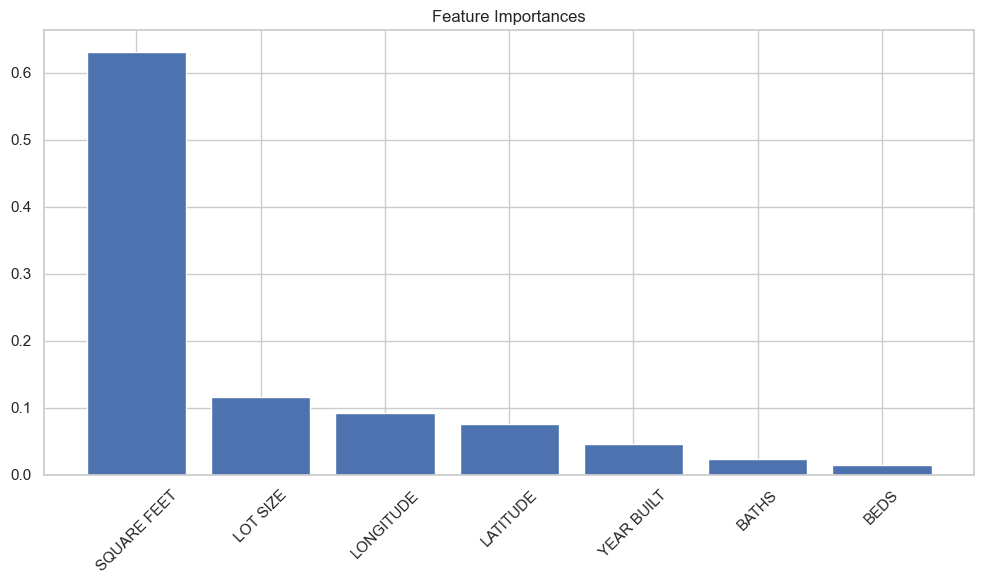

In [185]:
# --- Step 1: Select relevant columns ---
features = ['BEDS', 'BATHS', 'SQUARE FEET', 'LOT SIZE', 'YEAR BUILT',
            'LATITUDE', 'LONGITUDE']
target = 'PRICE'

# Make a copy of only the relevant data
df_model = df[features + [target]].copy()

# --- Step 2: Drop rows with missing values ---
df_model = df_model.dropna()

# --- Step 3: Train-test split ---
X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Step 4: Train Random Forest Regressor ---
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Step 5: Predict and Evaluate ---
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"MAE: ${mae:,.2f}")
print(f"RMSE: ${rmse:,.2f}")

# --- Step 6: Feature Importance Plot ---
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar([features[i] for i in indices], importances[indices])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

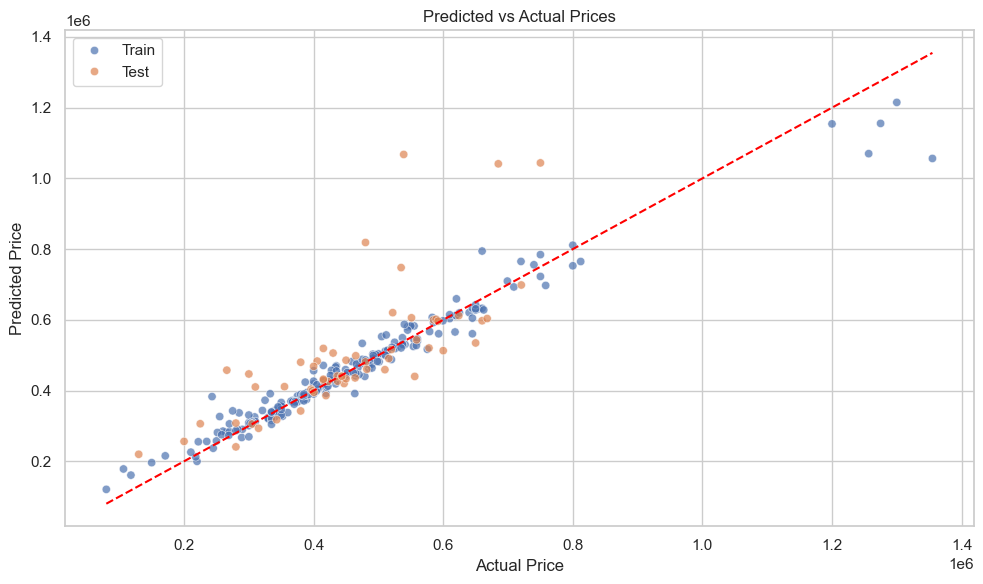

In [153]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=all_predictions, x='PRICE', y='PredictedPrice', hue='Data Split', alpha=0.7)
plt.plot([all_predictions['PRICE'].min(), all_predictions['PRICE'].max()],
         [all_predictions['PRICE'].min(), all_predictions['PRICE'].max()],
         color='red', linestyle='--')
plt.title('Predicted vs Actual Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.tight_layout()
plt.show()

In [191]:
all_predictions['ValuationDiff'] = all_predictions['PredictedPrice'] - all_predictions['PRICE']

In [195]:
overvalued = all_predictions.sort_values(by='ValuationDiff', ascending=False).head(10)
print("Most Over-Valued Properties:")
print(overvalued[['ADDRESS', 'Data Split', 'ZIPCODE', 'PRICE', 'PredictedPrice', 'ValuationDiff']])

Most Over-Valued Properties:
                       ADDRESS Data Split ZIPCODE   PRICE  PredictedPrice  \
285  3508 S Citrus Cir Unit GE       Test   32798  150000        479990.0   
256            249 S McGee Ave       Test   32703  106500        275611.0   
153             226 N Lake Ave      Train   32703  243200        406262.0   
130            191 Caldwell St       Test   32712  321000        483627.0   
277         1600 Crowncrest Dr       Test   32703  379995        529174.0   
265              1065 Cavan Dr       Test   32703  699000        834211.0   
156            1719 Finley Ave      Train   32703  480000        608336.0   
264             406 Jillson St       Test   32703  260000        379739.0   
148          908 Hilly Bend Dr       Test   32712  333000        448331.0   
192        674 Creeping Fig St      Train   32703  739990        849214.0   

     ValuationDiff  
285       329990.0  
256       169111.0  
153       163062.0  
130       162627.0  
277       149179.0

In [197]:
undervalued = all_predictions.sort_values(by='ValuationDiff').head(10)
print("Most Under-Valued Properties:")
print(undervalued[['ADDRESS', 'Data Split', 'ZIPCODE', 'PRICE', 'PredictedPrice', 'ValuationDiff']])

Most Under-Valued Properties:
                   ADDRESS Data Split ZIPCODE    PRICE  PredictedPrice  \
270  6115 Linneal Beach Dr       Test   32703  1275000        693315.0   
174           1322 Palm Dr      Train   32703  1355000        977445.0   
177      3141 Oak Alley Dr      Train   32703  1300000       1102450.0   
171      1526 Pinecliff Dr      Train   32703  1256627       1072943.0   
129          485 Halter Dr       Test   32712   575450        419326.0   
231      5203 Pineview Way      Train   32703  1200000       1061109.0   
132        493 Hebrides Ct       Test   32712   750000        614560.0   
278   2320 Blue Meadows Ct       Test   32703   556000        430010.0   
133    2639 Arbor Dune Ave       Test   32712   558474        463285.0   
254     1747 Crowncrest Dr      Train   32703   645000        550366.0   

     ValuationDiff  
270      -581685.0  
174      -377555.0  
177      -197550.0  
171      -183684.0  
129      -156124.0  
231      -138891.0  
132     